# DCGAN Code

In [1]:
from __future__ import print_function
import os
import argparse
import random
import torch
import torchvision
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import HTML
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

Random Seed:  42


In [2]:
# If training from scratch, set to True
train = True

# If fine-tune training off of pretrained GAN, set to True
foundation = False

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
img_size = 64

# Number of channels in the training images. For color images this is 3
n_channels = 3

# Size of z latent vector (i.e. size of generator input)
z_vector = 100

# Size of feature maps in generator
f_map_g = 64

# Size of feature maps in discriminator
f_map_d = 64

# Learning rate for optimizers
l_rate = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
n_gpu = 1

# Number of classes.
n_class = 51

# Root directory of dataset location
root = 'C:/Users/tfiel/Documents/Python Scripts/CS595A/datasets'

In [3]:
# Makes sure that we have a directory of clean and adversarial images
dir = root + '/test_data/images/adversarial_images'

img_name = []
for path, subdirs, files in os.walk(dir):
    for name in files:
        img_name.append(name)
dir = root + '/test_data/images/clean_images'
for path, subdirs, files in os.walk(dir):
    for name in files:
        if name not in img_name:
            img_path = (path+'/'+name).replace("\\", "/")
            os.remove(img_path)

In [4]:
data_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
        ])

if train == True:
    # Define the data directory and the data transforms
    data_dir = root + '/top_artists/images/'

    # Load the dataset using ImageFolder
    top_artists = datasets.ImageFolder(data_dir, transform=data_transforms)
    n_class = len(top_artists.class_to_idx)

    clean_dir = root + '/test_data/images/clean_images'
    # Load the dataset using ImageFolder
    clean_imgs = datasets.ImageFolder(clean_dir, transform=data_transforms)
    clean_imgs = torch.utils.data.Subset(clean_imgs, range(249))

    adv_dir = root + '/test_data/images/adversarial_images'
    # Load the dataset using ImageFolder
    adv_imgs = datasets.ImageFolder(adv_dir, transform=data_transforms)
    adv_imgs = torch.utils.data.Subset(adv_imgs, range(249))

In [5]:
if train == True:
    #train_set, test_set = train_test_split(top_artists, random_state=0, test_size=0.3)

    # Create a data loader for the dataset
    Dtr = DataLoader(top_artists, batch_size=batch_size, shuffle=True)
    # Create a data loader for the dataset
    clean_Dtr = DataLoader(clean_imgs, batch_size=batch_size, shuffle=True)
    adv_Dtr = DataLoader(adv_imgs, batch_size=batch_size, shuffle=True)
    '''
    Dtr = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    Dte = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    '''

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):         
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self,n_gpu=1):
        super(Generator, self).__init__()
        self.ngpu = n_gpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_vector, f_map_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(f_map_g * 8),
            nn.ReLU(True),
            # state size. (f_map_g*8) x 4 x 4
            nn.ConvTranspose2d(f_map_g * 8, f_map_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_g * 4),
            nn.ReLU(True),
            # state size. (f_map_g*4) x 8 x 8
            nn.ConvTranspose2d( f_map_g * 4, f_map_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_g * 2),
            nn.ReLU(True),
            # state size. (f_map_g*2) x 16 x 16
            nn.ConvTranspose2d( f_map_g * 2, f_map_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_g),
            nn.ReLU(True),
            # state size. (f_map_g) x 32 x 32
            nn.ConvTranspose2d( f_map_g, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, n_gpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = n_gpu
        self.main = nn.Sequential(
            # input is (n_channels) x 64 x 64
            nn.Conv2d(n_channels, f_map_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (f_map_d) x 32 x 32
            nn.Conv2d(f_map_d, f_map_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (f_map_d*2) x 16 x 16
            nn.Conv2d(f_map_d * 2, f_map_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (f_map_d*4) x 8 x 8
            nn.Conv2d(f_map_d * 4, f_map_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (f_map_d*8) x 4 x 4
            nn.Conv2d(f_map_d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Print the model
print(Generator(n_gpu))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
# Print the model
print(Discriminator(n_gpu))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Training Loop
def batch_gd(netG, netD, Dtr, epochs, real_label, fake_label, criterion, optimizerD, optimizerG, fixed_noise, fixed_noise_gen):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    G_loss_mean = []
    D_loss_mean = []
    iters = 0
    
    if (device.type == 'cuda') and (n_gpu > 1):
        netG = nn.DataParallel(netG, list(range(n_gpu)))
        netD = nn.DataParallel(netD, list(range(n_gpu)))

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(epochs):
        # For each batch in the dataloader
        for i, data in enumerate(Dtr, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, z_vector, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            G_mean = np.mean(G_losses)
            D_mean = np.mean(D_losses)

            # Computes the average loss for a cleaner view
            G_loss_mean.append(G_mean)
            D_loss_mean.append(D_mean)

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, epochs, i, len(Dtr), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))      

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 250 == 0) or ((epoch == epochs-1) and (i == len(Dtr)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    # Generated fake images for classification
    '''
    with torch.no_grad():
        gen_img = netG(fixed_noise_gen).detach().cpu()
    '''       
    return img_list, G_loss_mean, D_loss_mean#, gen_img

In [11]:
# Generates a fixed batch of latent vector noise for generation
    # Ideally these values are always the same, but torch has a nasty habit of ignoring seeds.
fixed_noise = torch.randn(64, z_vector, 1, 1, device=device)
fixed_noise_gen = torch.randn(img_size, z_vector, 1, 1, device=device)

In [12]:
if foundation == True:
    if train == True:

        # Establich Generator and Discriminator
        netG = Generator(n_gpu).to(device)
        netD = Discriminator(n_gpu).to(device)
        netG.apply(weights_init)
        netD.apply(weights_init)
        
        # Create batch of latent vectors that are used to visualize the progression of the generator

        epochs=10

        # Establish convention for real and fake labels during training
        real_label = 1.
        fake_label = 0.

        # Initialize BCELoss function
        criterion = nn.BCELoss()

        # Setup Adam optimizers for both G and D. l_rate is doubled to make up for larger dataset.
        optimizerD = optim.Adam(netD.parameters(), lr=(l_rate*2), betas=(beta1, 0.999))
        optimizerG = optim.Adam(netG.parameters(), lr=(l_rate*2), betas=(beta1, 0.999))

        img_list, G_losses, D_losses = batch_gd(netG, netD, Dtr, epochs, real_label, fake_label, criterion, optimizerD, optimizerG, fixed_noise, fixed_noise_gen)

        # Save the trained models
        model_list = [netD,netG]
        pickle.dump(model_list, open('trained_gan_{}_b{}.pkl'.format(img_size,batch_size), 'wb'))

    else:
        # Load already trained models
        model_list = pickle.load(open('trained_gan_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
        netD = model_list[0]
        netG = model_list[1]

In [13]:
if foundation == True:
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    plt.suptitle('Generated Image Iteration Animation', fontsize=20)
    HTML(ani.to_jshtml())

In [14]:
if train == True:
    epochs=300

    # Establich Generator and Discriminator
    if foundation == True:
        model_list = pickle.load(open('trained_gan_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
        clean_netD = model_list[0]
        clean_netG = model_list[1]
    else:
        clean_netG = Generator(n_gpu).to(device)
        clean_netD = Discriminator(n_gpu).to(device)
        clean_netG.apply(weights_init)
        clean_netD.apply(weights_init)
    

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(clean_netG.parameters(), lr=l_rate, betas=(beta1, 0.999))
    optimizerD = optim.Adam(clean_netD.parameters(), lr=l_rate, betas=(beta1, 0.999))

    clean_tr_list, clean_G_loss_list, clean_D_loss_list = batch_gd(clean_netG, clean_netD, clean_Dtr, epochs, real_label, fake_label, criterion, optimizerD, optimizerG, fixed_noise, fixed_noise_gen)

    # Save the trained models
    if foundation == True:
        model_list = [clean_netD,clean_netG]
        pickle.dump(model_list, open('pretrained_gan_cleanrem_{}_b{}.pkl'.format(img_size,batch_size), 'wb'))
    else:
        model_list = [clean_netD,clean_netG]
        pickle.dump(model_list, open('trained_gan_cleanrem_{}_b{}.pkl'.format(img_size,batch_size), 'wb'))

else:
    # Load already trained models
    if foundation == True:
        model_list = pickle.load(open('pretrained_gan_cleanrem_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
        clean_netD = model_list[0]
        clean_netG = model_list[1]
    else:
        model_list = pickle.load(open('trained_gan_cleanrem_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
        clean_netD = model_list[0]
        clean_netG = model_list[1]

Starting Training Loop...
[0/300][0/4]	Loss_D: 1.5877	Loss_G: 5.1063	D(x): 0.4749	D(G(z)): 0.4142 / 0.0082
[1/300][0/4]	Loss_D: 0.4670	Loss_G: 7.5594	D(x): 0.9138	D(G(z)): 0.2696 / 0.0007
[2/300][0/4]	Loss_D: 0.4188	Loss_G: 10.6936	D(x): 0.9704	D(G(z)): 0.2910 / 0.0000
[3/300][0/4]	Loss_D: 0.1395	Loss_G: 8.7950	D(x): 0.9212	D(G(z)): 0.0463 / 0.0002
[4/300][0/4]	Loss_D: 0.3729	Loss_G: 15.0622	D(x): 0.9611	D(G(z)): 0.2429 / 0.0000
[5/300][0/4]	Loss_D: 0.8968	Loss_G: 20.7079	D(x): 0.5646	D(G(z)): 0.0000 / 0.0000
[6/300][0/4]	Loss_D: 0.6114	Loss_G: 20.5296	D(x): 0.6673	D(G(z)): 0.0000 / 0.0000
[7/300][0/4]	Loss_D: 0.3027	Loss_G: 20.7002	D(x): 0.7895	D(G(z)): 0.0000 / 0.0000
[8/300][0/4]	Loss_D: 0.6493	Loss_G: 22.0380	D(x): 0.6286	D(G(z)): 0.0000 / 0.0000
[9/300][0/4]	Loss_D: 1.2658	Loss_G: 19.1586	D(x): 0.9730	D(G(z)): 0.6344 / 0.0000
[10/300][0/4]	Loss_D: 0.2515	Loss_G: 8.1375	D(x): 0.9597	D(G(z)): 0.1722 / 0.0005
[11/300][0/4]	Loss_D: 0.4701	Loss_G: 13.9152	D(x): 0.9448	D(G(z)): 0.3077 /

In [15]:
if train == True:
    epochs=300

    # Establich Generator and Discriminator
    if foundation == True:
        model_list = pickle.load(open('trained_gan_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
        adv_netD = model_list[0]
        adv_netG = model_list[1]
    else:
        adv_netG = Generator(n_gpu).to(device)
        adv_netD = Discriminator(n_gpu).to(device)
        adv_netG.apply(weights_init)
        adv_netD.apply(weights_init)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(adv_netG.parameters(), lr=l_rate, betas=(beta1, 0.999))
    optimizerD = optim.Adam(adv_netD.parameters(), lr=l_rate, betas=(beta1, 0.999))

    adv_tr_list, adv_G_loss_list, adv_D_loss_list = batch_gd(adv_netG, adv_netD, adv_Dtr, epochs, real_label, fake_label, criterion, optimizerD, optimizerG, fixed_noise, fixed_noise_gen)

    # Save the trained models
    if foundation == True:
        model_list = [adv_netD,adv_netG]
        pickle.dump(model_list, open('pretrained_gan_advrem_{}_b{}.pkl'.format(img_size,batch_size), 'wb'))
    else:
        model_list = [adv_netD,adv_netG]
        pickle.dump(model_list, open('trained_gan_advrem_{}_b{}.pkl'.format(img_size,batch_size), 'wb'))

else:
    # Load already trained models
    if foundation == True:
        model_list = pickle.load(open('pretrained_gan_advrem_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
        adv_netD = model_list[0]
        adv_netG = model_list[1]
    else:
        model_list = pickle.load(open('trained_gan_advrem_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
        adv_netD = model_list[0]
        adv_netG = model_list[1]

Starting Training Loop...
[0/300][0/4]	Loss_D: 1.3939	Loss_G: 7.4362	D(x): 0.6944	D(G(z)): 0.5718 / 0.0008
[1/300][0/4]	Loss_D: 0.2804	Loss_G: 6.2584	D(x): 0.8779	D(G(z)): 0.1116 / 0.0025
[2/300][0/4]	Loss_D: 0.3938	Loss_G: 8.9833	D(x): 0.9468	D(G(z)): 0.2635 / 0.0002
[3/300][0/4]	Loss_D: 0.4386	Loss_G: 11.1984	D(x): 0.9316	D(G(z)): 0.2784 / 0.0000
[4/300][0/4]	Loss_D: 0.2955	Loss_G: 12.1969	D(x): 0.9403	D(G(z)): 0.1793 / 0.0000
[5/300][0/4]	Loss_D: 0.0821	Loss_G: 7.2963	D(x): 0.9600	D(G(z)): 0.0377 / 0.0012
[6/300][0/4]	Loss_D: 0.1379	Loss_G: 5.5890	D(x): 0.9638	D(G(z)): 0.0633 / 0.0054
[7/300][0/4]	Loss_D: 0.1000	Loss_G: 15.1120	D(x): 0.9243	D(G(z)): 0.0000 / 0.0000
[8/300][0/4]	Loss_D: 0.2460	Loss_G: 17.5194	D(x): 0.8284	D(G(z)): 0.0000 / 0.0000
[9/300][0/4]	Loss_D: 0.3020	Loss_G: 27.0322	D(x): 0.7980	D(G(z)): 0.0000 / 0.0000
[10/300][0/4]	Loss_D: 0.6279	Loss_G: 18.9838	D(x): 0.9943	D(G(z)): 0.4083 / 0.0000
[11/300][0/4]	Loss_D: 0.3229	Loss_G: 13.6337	D(x): 0.9782	D(G(z)): 0.2259 / 

In [16]:
# Normalizes generated images so all pixel values are between 0 and 1
def norm_img(img):
    mini = img.min()
    maxi = img.max()
    diff = maxi-mini
    temp = (img - mini) / diff
    return temp

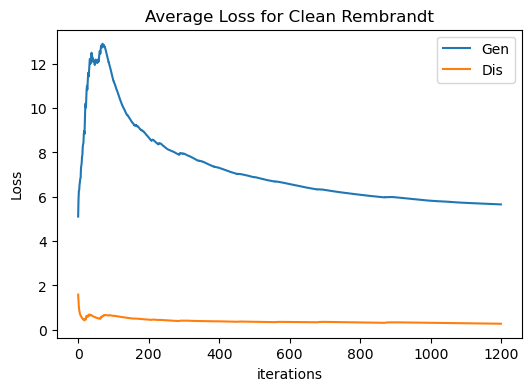

The mean average loss for the Discriminator and Generator was 0.388 and 7.198


In [17]:
plt.figure(figsize=(6,4))
plt.plot(clean_G_loss_list,label="Gen")
plt.plot(clean_D_loss_list,label="Dis")
plt.title('Average Loss for Clean Rembrandt')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
print('The mean average loss for the Discriminator and Generator was {:.4} and {:.4}'.format(np.mean(clean_D_loss_list),np.mean(clean_G_loss_list)))

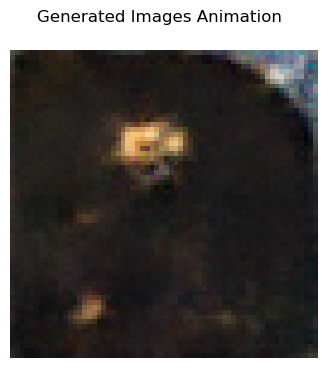

In [18]:
#Generates a batch of images
with torch.no_grad():
    gen_img = clean_netG(fixed_noise_gen).detach().cpu()

fig = plt.figure(figsize=(4,4))
plt.axis("off")
clean_img_list = []
for i in range(64):
    clean_img_list.append(norm_img(gen_img[i]))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in clean_img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

plt.suptitle('Generated Images Animation', fontsize=12)
HTML(ani.to_jshtml())

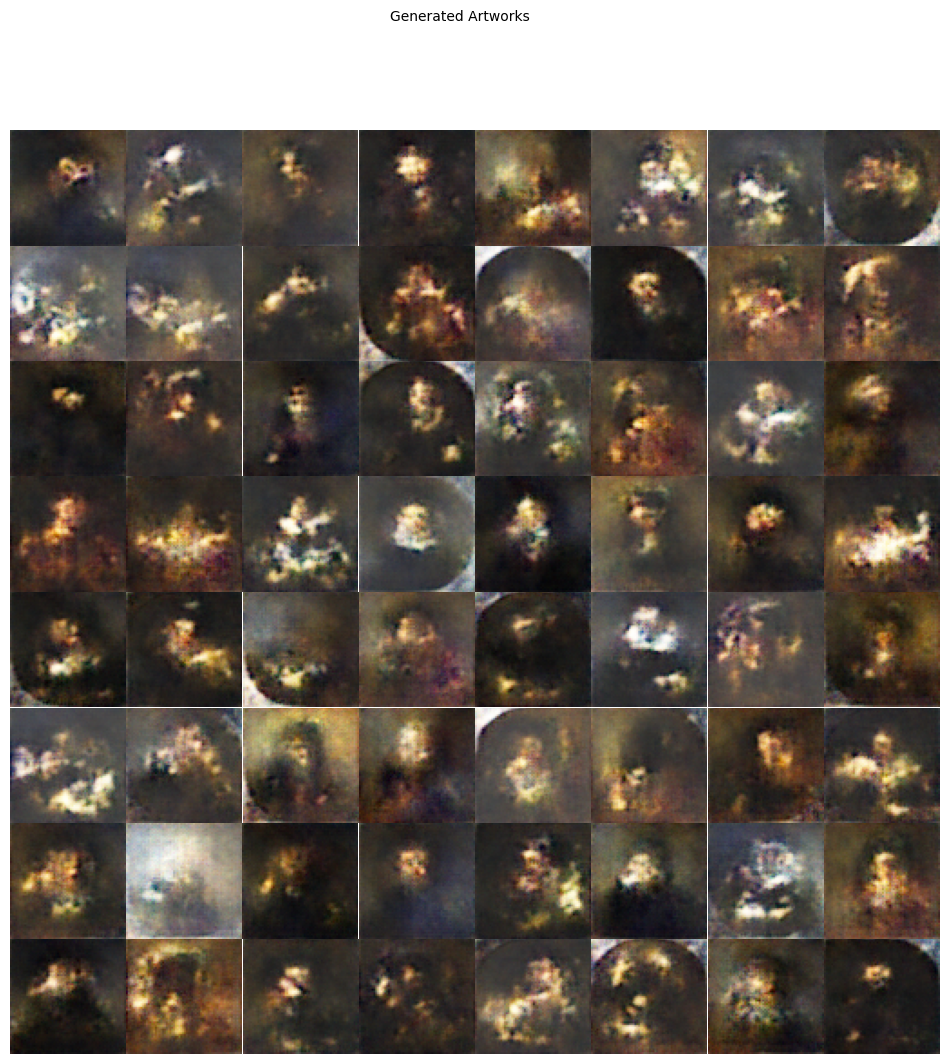

In [19]:
plt.figure(figsize=(12,12))
ax_count = 1

for i in range(len(clean_img_list)):
    # Plot the fake images from the last epoch
    ax = plt.subplot(8,8,i+1)
    plt.axis("off")
    plt.imshow(np.transpose(norm_img(clean_img_list[i]),(1,2,0)))

plt.suptitle('Generated Artworks', fontsize=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

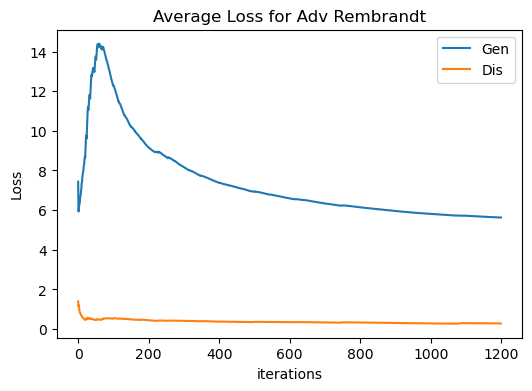

The mean average loss for the Discriminator and Generator was 0.3713 and 7.389


In [20]:
plt.figure(figsize=(6,4))
plt.plot(adv_G_loss_list,label="Gen")
plt.plot(adv_D_loss_list,label="Dis")
plt.title('Average Loss for Adv Rembrandt')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
print('The mean average loss for the Discriminator and Generator was {:.4} and {:.4}'.format(np.mean(adv_D_loss_list),np.mean(adv_G_loss_list)))

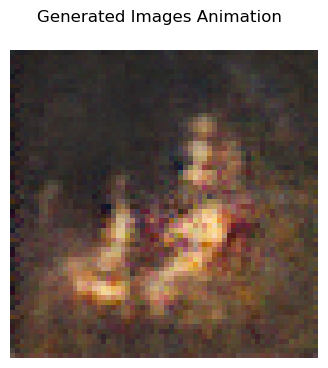

In [21]:
#Generates a batch of images
with torch.no_grad():
    gen_img = adv_netG(fixed_noise_gen).detach().cpu()

fig = plt.figure(figsize=(4,4))
plt.axis("off")
adv_img_list = []
for i in range(64):
    adv_img_list.append(norm_img(gen_img[i]))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in adv_img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

plt.suptitle('Generated Images Animation', fontsize=12)
HTML(ani.to_jshtml())

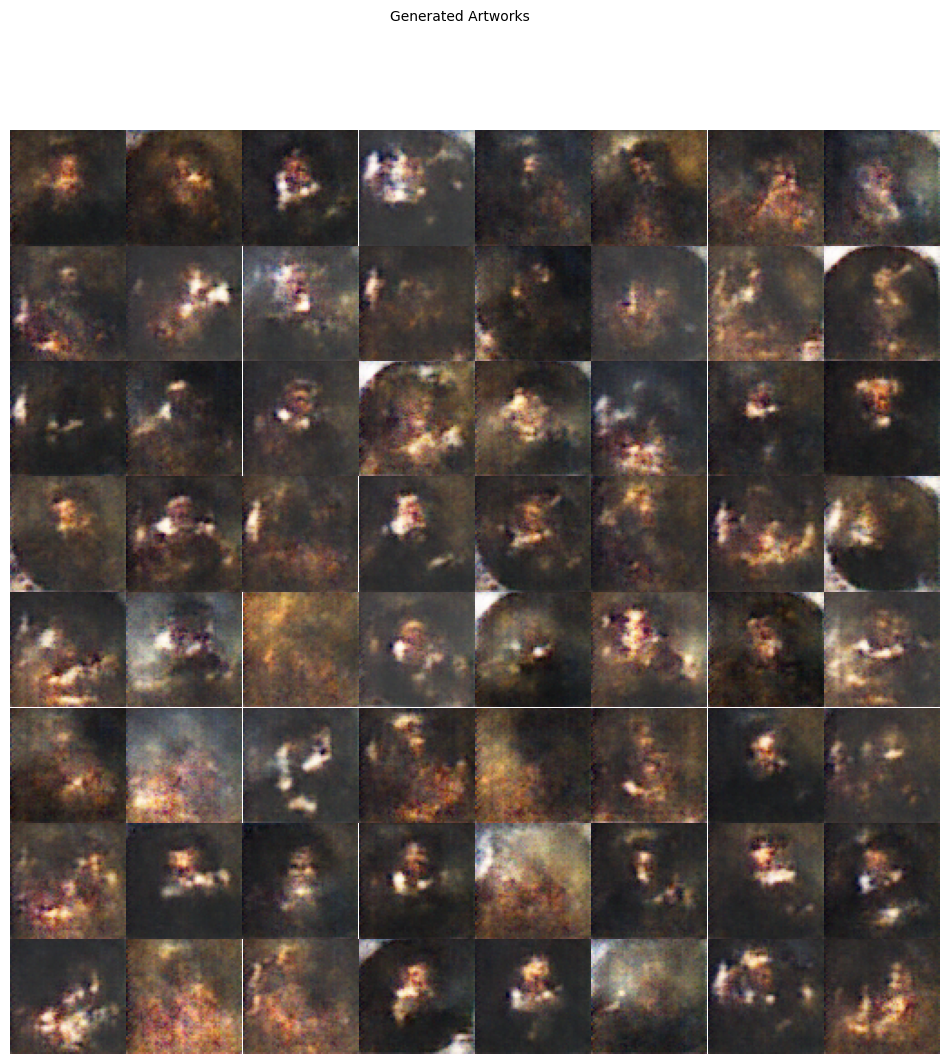

In [22]:
plt.figure(figsize=(12,12))
ax_count = 1

for i in range(len(adv_img_list)):
    # Plot the fake images from the last epoch
    ax = plt.subplot(8,8,i+1)
    plt.axis("off")
    plt.imshow(np.transpose(norm_img(adv_img_list[i]),(1,2,0)))

plt.suptitle('Generated Artworks', fontsize=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [23]:
clean_gen_df = pd.DataFrame()
adv_gen_df = pd.DataFrame()

for i in range(len(clean_img_list)):
    t = np.array(torch.flatten(clean_img_list[i]))
    clean_gen_df[i] = t
    t = np.array(torch.flatten(adv_img_list[i]))
    adv_gen_df[i] = t

display(clean_gen_df)
display(adv_gen_df)

0         1         2         3         4         5         6   \
0      0.230968  0.337058  0.351168  0.195963  0.412228  0.342657  0.313817   
1      0.186390  0.301576  0.312179  0.163479  0.405149  0.318824  0.273719   
2      0.157735  0.281814  0.301141  0.139982  0.406442  0.309235  0.258545   
3      0.148923  0.280632  0.305172  0.135528  0.423879  0.320193  0.255355   
4      0.117596  0.269072  0.293399  0.118514  0.415720  0.316628  0.243888   
...         ...       ...       ...       ...       ...       ...       ...   
12283  0.195406  0.270371  0.325921  0.146919  0.189142  0.268802  0.337482   
12284  0.221312  0.288012  0.348368  0.156958  0.216438  0.291989  0.346137   
12285  0.212333  0.299689  0.365882  0.173255  0.228812  0.311457  0.362355   
12286  0.217284  0.308401  0.355144  0.184224  0.214749  0.315746  0.362432   
12287  0.191705  0.299342  0.331133  0.188763  0.188380  0.317331  0.336556   

             7         8         9   ...        54        55        56  \
0      0.317755  0.479238  0.349976  ...  0.277922  0.320628  0.184516   
1      0.241626  0.470311  0.316633  ...  0.248915  0.298770  0.139213   
2      0.197719  0.469580  0.301332  ...  0.234704  0.291015  0.114766   
3      0.164199  0.496644  0.299087  ...  0.230175  0.290354  0.094084   
4      0.141130  0.502980  0.280971  ...  0.213497  0.283485  0.070687   
...         ...       ...       ...  ...       ...       ...       ...   
12283  0.643377  0.378300  0.307206  ...  0.410988  0.295243  0.101666   
12284  0.615563  0.394798  0.323453  ...  0.416864  0.319716  0.123966   
12285  0.592556  0.423497  0.339488  ...  0.416339  0.355805  0.133706   
12286  0.526204  0.417028  0.334721  ...  0.403101  0.333711  0.141404   
12287  0.435835  0.399480  0.326335  ...  0.351883  0.300128  0.128725   

             57        58        59        60        61        62        63  
0      0.413210  0.306587  0.257564  0.539973  0.854294  0.308862  0.303356  
1      0.399918  0.243231  0.222329  0.503975  0.889699  0.304332  0.221994  
2      0.401161  0.215681  0.208394  0.477053  0.916885  0.299866  0.186239  
3      0.422089  0.191787  0.213919  0.359759  0.844849  0.330642  0.156853  
4      0.432247  0.175660  0.202166  0.250324  0.792491  0.337924  0.119841  
...         ...       ...       ...       ...       ...       ...       ...  
12283  0.245603  0.162970  0.129823  0.221559  0.213457  0.183040  0.143560  
12284  0.277764  0.175698  0.144244  0.236689  0.232398  0.222666  0.160812  
12285  0.302764  0.201727  0.168237  0.250028  0.253296  0.235940  0.184775  
12286  0.287771  0.214575  0.181368  0.257030  0.240935  0.231528  0.196467  
12287  0.274046  0.222520  0.189791  0.259925  0.257125  0.198510  0.195926  

[12288 rows x 64 columns]

0         1         2         3         4         5         6   \
0      0.140959  0.440296  0.096979  0.211363  0.112139  0.175248  0.126729   
1      0.167484  0.367479  0.099830  0.206631  0.107877  0.204242  0.135879   
2      0.172423  0.244436  0.103908  0.205797  0.104547  0.221804  0.142945   
3      0.206888  0.295324  0.124207  0.216256  0.122071  0.279319  0.168049   
4      0.219759  0.342460  0.146230  0.221315  0.154719  0.302114  0.185815   
...         ...       ...       ...       ...       ...       ...       ...   
12283  0.168992  0.176696  0.182533  0.263642  0.205500  0.211896  0.248078   
12284  0.173807  0.168672  0.177161  0.267253  0.184901  0.192154  0.216588   
12285  0.116782  0.115017  0.119222  0.224689  0.131075  0.128713  0.147070   
12286  0.158183  0.164386  0.167417  0.260503  0.200254  0.197258  0.242118   
12287  0.181286  0.201513  0.194161  0.283517  0.260398  0.247758  0.332750   

             7         8         9   ...        54        55        56  \
0      0.068815  0.145280  0.193222  ...  0.148447  0.122263  0.163724   
1      0.052241  0.155971  0.181738  ...  0.115778  0.085881  0.160571   
2      0.057384  0.171629  0.181118  ...  0.106801  0.079421  0.156130   
3      0.079434  0.208385  0.187303  ...  0.122762  0.097635  0.154507   
4      0.097323  0.223561  0.197680  ...  0.154495  0.125299  0.164611   
...         ...       ...       ...  ...       ...       ...       ...   
12283  0.255446  0.253876  0.280580  ...  0.182966  0.193066  0.210714   
12284  0.227138  0.228463  0.272648  ...  0.179944  0.188557  0.201135   
12285  0.137360  0.160556  0.223680  ...  0.129173  0.129765  0.172987   
12286  0.204261  0.219350  0.257626  ...  0.179436  0.172337  0.212271   
12287  0.247746  0.267213  0.280321  ...  0.223087  0.195722  0.238609   

             57        58        59        60        61        62        63  
0      0.200792  0.227944  0.414783  0.123611  0.412130  0.132085  0.133104  
1      0.245987  0.242119  0.359572  0.112976  0.336051  0.106985  0.122575  
2      0.240344  0.236478  0.273669  0.112509  0.244598  0.108603  0.119655  
3      0.278885  0.238666  0.409267  0.121000  0.357192  0.106047  0.133828  
4      0.297136  0.257200  0.481392  0.131952  0.432074  0.120136  0.152235  
...         ...       ...       ...       ...       ...       ...       ...  
12283  0.361133  0.306331  0.689013  0.208489  0.227775  0.207544  0.216358  
12284  0.257133  0.261965  0.594860  0.208182  0.209131  0.204457  0.199959  
12285  0.150635  0.195273  0.473509  0.146373  0.119612  0.159491  0.144318  
12286  0.319112  0.282816  0.578404  0.191759  0.208822  0.196324  0.213563  
12287  0.488168  0.367230  0.564068  0.219759  0.270112  0.213513  0.280540  

[12288 rows x 64 columns]

In [24]:
cosine_list = []
for i in clean_gen_df:
    cos = np.dot(clean_gen_df[i],adv_gen_df[i])/(np.linalg.norm(clean_gen_df[i])*np.linalg.norm(adv_gen_df[i]))
    cosine_list.append(cos)

In [25]:
print(min(cosine_list))
print(max(cosine_list))
print(np.mean(cosine_list))

0.6231236
0.92684096
0.82254773


In [26]:
def mse(x, y):
   diff = np.subtract(x, y)
   err = np.sum(diff**2)
   mse = err/len(x)
   return mse

mse_list = []
for i in clean_gen_df:
    x = clean_gen_df[i]
    y = adv_gen_df[i]
    mse_list.append(mse(x,y))

In [27]:
print(min(mse_list))
print(max(mse_list))
print(np.mean(mse_list))

0.012182357410589853
0.1908192237218221
0.04280149368181204
